
# Fraud Detection

In [3]:
%matplotlib inline

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

np.random.seed(1)

In [4]:
claims = pd.read_csv("report.csv")
claims.shape

(43157, 14)

In [5]:
claims.head()

,claimnumber,name,updatetime,lossdate,fault,fraud,insured_sex,insured_occupation,auto_make,months_as_customer,insured_state,incident_severity,property_damage,bodily_injuries
0,42-3069,Collision Rear-end,14:50.4,11/17/2017 1:12,0.0,0.0,male,6.0,SMART,44.0,PA,Major Damage,YES,1.0
1,42-3082,Collision while Backing,18:32.5,11/16/2018 4:17,100.0,1.0,male,1.0,SUBARU,1.0,CA,Minor Damage,?,0.0
2,42-3083,Collision while Parked,49:28.0,8/30/2017 12:29,0.0,0.0,female,4.0,SMART,66.0,CA,Minor Damage,NO,2.0
3,42-3085,Animal,19:42.9,8/26/2018 0:16,0.0,0.0,female,5.0,OTHER,38.0,CA,Major Damage,?,1.0
4,42-3088,Collision Hit and Run,27:53.3,12/1/2017 0:02,0.0,0.0,female,6.0,SUBARU,8.0,PA,Minor Damage,NO,0.0


### Missing Values

Text(0.5, 1.0, 'Missing Values')

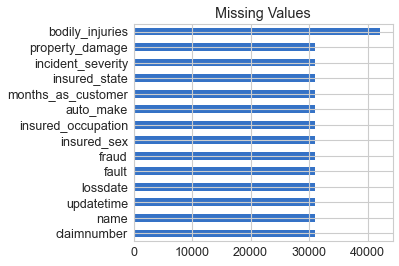

In [6]:
# Number of missing values per feature
fig, ax = plt.subplots()
claims.isna().sum().plot(kind = 'barh', ax= ax)
fig.subplots_adjust(left= 0.3)
ax.set_title("Missing Values")
#fig.savefig('NAs.png')

Bodily injuries is almost missing the entire dataset. 

Let's see which observations are missing when we omit that column.

In [7]:
# Which observations have missing values
claims.drop('bodily_injuries', axis = 1).isna().any(axis = 1).sum()

31192

In [8]:
# Get raw numbers from bar plot
claims.isna().sum()

claimnumber           30936
name                  30936
updatetime            30936
lossdate              30936
fault                 30936
fraud                 30936
insured_sex           30953
insured_occupation    31046
auto_make             30959
months_as_customer    30973
insured_state         30936
incident_severity     30936
property_damage       31009
bodily_injuries       42157
dtype: int64

31,192 observations have missing values. Each column has roughly 31,000 missing values. 

This means that there is significant overlap in the NA values. Because of this, I plan on dropping the entire observation if the row is all NA.

In [9]:
claims = claims[claims.drop('bodily_injuries', axis= 1).notnull().any(axis= 1)]
claims.shape

(12221, 14)

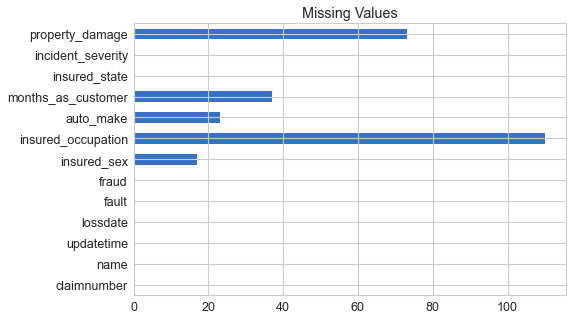

In [10]:
fig, ax = plt.subplots(figsize= (10,5))
claims.drop('bodily_injuries', axis= 1).isna().sum().plot(kind= 'barh', ax= ax)
ax.set_title("Missing Values")
fig.subplots_adjust(left= 0.3)
fig.savefig('NAs_2.png')

In [11]:
claims.drop('bodily_injuries', axis= 1).isna().sum().sum()

260

In [12]:
# Observations with any NAs, excluding "bodily_injuries"
claims.drop('bodily_injuries', axis = 1).isna().any(axis = 1).sum()

256

We already knew bodily_injures was missing the majority of the data. Now we're only missing a small fraction of the data. The rest of the NAs are distributed across different observations for a total of 256 observations with some missing value (again ignoring bodily injuries). Given that this is only 2% of the remaining data, I feel comfortable that dropping these observations will not lead to a significant decrease in predictive power.

In [13]:
# Drop observations with any NA, exlcuding "bodily_injuries"
claims = claims[~claims.drop('bodily_injuries', axis= 1).isna().any(axis= 1)].reset_index(drop= True)
# Final shape of claims
claims.shape

(11965, 14)

## Data Integrity of Features

### Feature: claimnumber

In [14]:
claims.shape[0] - len(pd.unique(claims['claimnumber']))

336

We have 336 repeated claim numbers

In [15]:
duplicates = claims[claims.duplicated(subset= 'claimnumber')]
duplicates.head()

,claimnumber,name,updatetime,lossdate,fault,fraud,insured_sex,insured_occupation,auto_make,months_as_customer,insured_state,incident_severity,property_damage,bodily_injuries
9,42-3097,Collision Other,25:53.6,3/10/2018 0:45,0.0,0.0,female,8.0,MERCEDES-BENZ,44.0,CA,Total Loss,NO,2.0
73,42-3310,Comprehensive Other,59:14.3,9/9/2017 7:35,0.0,1.0,male,7.0,MERCEDES-BENZ,3.0,CA,Minor Damage,NO,1.0
90,42-3380,Vandalism,23:43.1,5/26/2018 20:20,0.0,0.0,male,3.0,SUZUKI,44.0,PA,Major Damage,NO,1.0
120,42-3508,Collision Hit and Run,22:57.1,10/21/2017 5:18,0.0,0.0,male,4.0,OTHER,60.0,PA,Total Loss,NO,2.0
129,42-3549,Collision Hit and Run,27:42.1,6/2/2018 2:54,0.0,0.0,female,2.0,MERCEDES-BENZ,23.0,CA,Minor Damage,?,1.0


In [16]:
# Examine one of the duplicates - looks very different
claims[claims['claimnumber'] == '42-3380'].drop(['updatetime', 'insured_occupation', 'property_damage'], axis= 1)

,claimnumber,name,lossdate,fault,fraud,insured_sex,auto_make,months_as_customer,insured_state,incident_severity,bodily_injuries
89,42-3380,Glass Only,4/4/2018 7:57,0.0,0.0,female,OTHER,60.0,CA,Trivial Damage,0.0
90,42-3380,Vandalism,5/26/2018 20:20,0.0,0.0,male,SUZUKI,44.0,PA,Major Damage,1.0


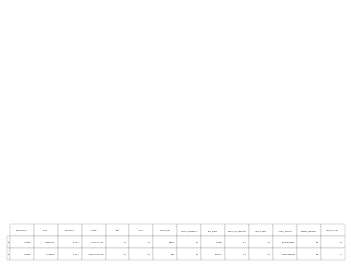

In [17]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

pd.plotting.table(ax, claims[claims['claimnumber'] == '42-3380'])  # where df is your data frame

plt.savefig('mytable.png')

The Data Challenge sheet says that the data provided is transactional so any changes made to the claim will be a new observation. From comparing the same claim number, they appear to be two completely separate incidents. Different state, sex, occupation, auto make, state, etc. With more time, I would research more into this and consider treating them as separate incidents if that is what seems right. For this challenge I will choose to omit the duplicated values.

In [18]:
claims.drop_duplicates(subset= 'claimnumber', ignore_index= True, inplace= True)

### Feature: name

In [19]:
for claim in claims['name'].unique():
    print(claim)

Collision Rear-end
Collision while Backing
Collision while Parked 
Animal
Collision Hit and Run
Collision Rearend
Collision with Fixed Object
Vandalism
Collision at Intersection
Comprehensive Other 
Glass Only 
Collision while Turning 
Theft of Entire Vehicle
Collision at Intersect
Collision Other
Impact with Falling/Flying Object
Collision while Parking 
Collision Rollaway/Unattended
Theft Audio
Collision Solo Accident
All Risk - Mechanical (paint, brakes, all other)
Collision while Changing Lanes
Collision with Bicycle
Collision with Pedestrian
Collision with Motorcycle 
Collision with Motor Vehicle
Fire
Collision with Train or Bus
Explosion
Pedestrian/Insured Injury Only 
Water
Windstorm
Hail


We see "Collision Rear-end" and "Collision rearend" which are presumably the same type of loss. Similarly, we see "Collision at Intersect" and "Collision at Intersection". 

In [20]:
# Rearend to Rear-end
claims.loc[claims[claims['name'] == "Collision Rearend"].index, 'name'] = 'Collision Rear-end'

In [21]:
# Intersect to Intersection
claims.loc[claims[claims['name'] == "Collision at Intersect"].index, 'name'] = 'Collision at Intersection'

In [22]:
# change to lowercase
claims['name'] = claims['name'].apply(str.lower)

### Feature: updatetime 

In [23]:
claims['updatetime'].dtype

dtype('O')

In [24]:
claims['updatetime'].head()

0    14:50.4
1    18:32.5
2    49:28.0
3    19:42.9
4    27:53.3
Name: updatetime, dtype: object

In [25]:
claims['updatetime'].max()

'59:59.9'

In [26]:
claims['updatetime'].min()

'00:00.0'

Updatetime appears to be a minute:second.millisecond time as it ranges from 0 to 60

In [27]:
def strip_updatetime(updatetime):
    """
    Function to convert updatetime to total seconds
    """
    
    dt = datetime.datetime.strptime(updatetime, "%M:%S.%f")
    total_seconds = dt.minute*60 + dt.second + dt.microsecond/1000000
    
    return str(total_seconds)

In [28]:
claims['updatetime'] = claims['updatetime'].apply(lambda x: strip_updatetime(x)).astype('float64')

Transformed updatetime to a numerical value for models to interpret

### Feature: lossdate

Will also spend this section to convert the actual date to a number for the model

In [29]:
# convert lossdate to datetime
claims['lossdate'].dtype

dtype('O')

In [30]:
claims['lossdate'] = pd.to_datetime(claims['lossdate'])

In [31]:
# create new column that is seconds from the earliest recorded date
earliest_date = claims['lossdate'].min()
claims['seconds_since_earliest_date'] = (claims['lossdate'] - earliest_date).apply(lambda x: x.total_seconds())

### Feature: fault

In [32]:
claims['fault'].unique()

array([  0., 100.,  50.,  40.,  60.,  80.,  20.,  95.,  15.,  70.,  10.,
        30.,  75.,  85.,  90.])

In [33]:
# change to int
claims['fault'] = claims['fault'].astype('int64')

In [34]:
# looks good
claims['fault'].unique()

array([  0, 100,  50,  40,  60,  80,  20,  95,  15,  70,  10,  30,  75,
        85,  90], dtype=int64)

### Feature: fraud

In [35]:
claims['fraud'].unique()

array([0., 1.])

In [36]:
# change to int
claims['fraud'] = claims['fraud'].astype('int64')

In [37]:
# looks good
claims['fraud'].unique()

array([0, 1], dtype=int64)

### Feature: insured_sex

In [38]:
claims['insured_sex'].unique()

array(['male', 'female', 'nonConforming'], dtype=object)

In [39]:
# change to all lowercase
claims['insured_sex'] = claims['insured_sex'].apply(str.lower)

### Feature: insured_occupation

In [40]:
claims['insured_occupation'].unique()

array([ 6.,  1.,  4.,  5.,  7.,  2.,  3.,  8., 10.])

In [41]:
# change to int
claims['insured_occupation'] = claims['insured_occupation'].astype('int64')

In [42]:
# looks good
claims['insured_occupation'].unique()

array([ 6,  1,  4,  5,  7,  2,  3,  8, 10], dtype=int64)

### Feature: auto_make

In [43]:
for claim in claims['auto_make'].unique():
    print(claim)

SMART
SUBARU
OTHER
TOYOTA
SUZUKI
NISSAN
VOLKSWAGEN
MERCEDES-BENZ
VOLVO
SUBUWU
TESLA


In [44]:
# SUBUWU to SUBARU
claims.loc[claims[claims['auto_make'] == 'SUBUWU'].index, "auto_make"] = "SUBARU"

In [45]:
# looks good
for claim in claims['auto_make'].unique():
    print(claim)

SMART
SUBARU
OTHER
TOYOTA
SUZUKI
NISSAN
VOLKSWAGEN
MERCEDES-BENZ
VOLVO
TESLA


### Feature: months_as_customer

In [46]:
claims['months_as_customer'].unique()

array([44.,  1., 66., 38.,  8., 12., 24., 23., 28., 60., 15., 68., 32.,
        4., 35.,  3., 42., 30., 25., 50., 20., 70., 22., 40.,  5., 51.,
        2.,  7.,  6., 80.,  9.])

In [47]:
claims['months_as_customer'] = claims['months_as_customer'].astype('int64')

In [48]:
claims['months_as_customer'].unique()

array([44,  1, 66, 38,  8, 12, 24, 23, 28, 60, 15, 68, 32,  4, 35,  3, 42,
       30, 25, 50, 20, 70, 22, 40,  5, 51,  2,  7,  6, 80,  9],
      dtype=int64)

### Feature: insured_state

In [49]:
# looks good
claims['insured_state'].unique()

array(['PA', 'CA', 'AZ'], dtype=object)

### Feature: incident_severity

In [50]:
# looks good
claims['incident_severity'].unique()

array(['Major Damage', 'Minor Damage', 'Total Loss', 'Trivial Damage'],
      dtype=object)

### Feature: property_damage

In [51]:
# looks good
claims['property_damage'].unique()

array(['YES', '?', 'NO'], dtype=object)

### Feature: bodily_injuries

In [52]:
claims['bodily_injuries'].unique()

array([ 1.,  0.,  2., nan])

## Top 3 Claims over time

In [53]:
top_claims = claims.copy()
top_claims['lossdate'] = pd.to_datetime(top_claims['lossdate'])
top_claims = top_claims.set_index("lossdate")

# Date Range
print("Earliest Date: ", top_claims.index.min())
print("Latest Date: ", top_claims.index.max())

Earliest Date:  2017-01-01 00:02:00
Latest Date:  2018-12-31 23:02:00


In [54]:
# get number of claims by month
monthly_top_claims = top_claims.groupby("name").resample("1m").size()

# reset index and rename column
monthly_top_claims = monthly_top_claims.reset_index(level= 'name').rename(columns= {0: 'num_claims'})

# sort in descending order by number of claims
monthly_top_claims = monthly_top_claims.groupby(by= 'lossdate').apply(lambda x: x.sort_values(["num_claims"], ascending= False))

# grab top 3 claims per month
monthly_top_claims = monthly_top_claims.reset_index(level = 1, drop= True).groupby(["lossdate"]).head(3)

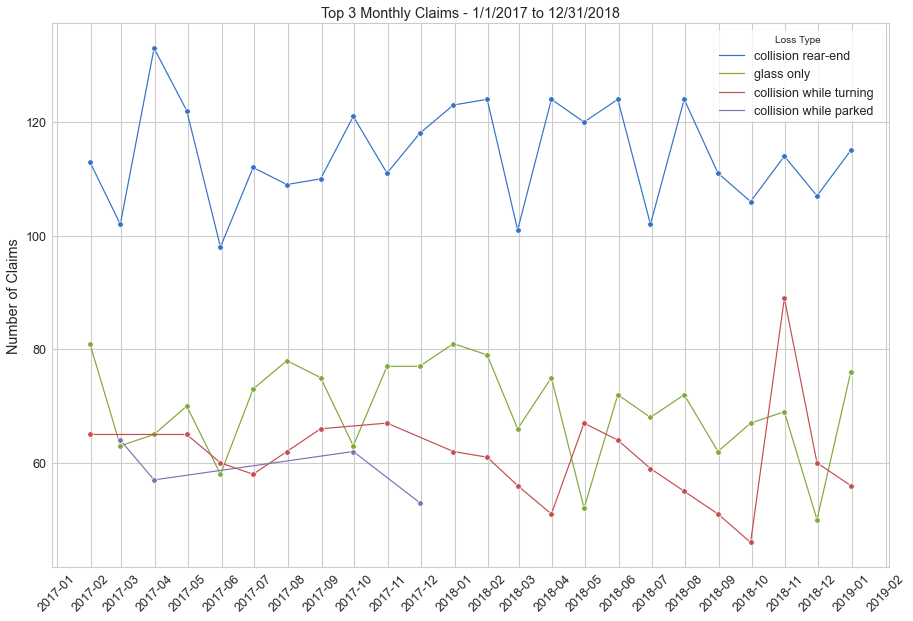

In [80]:
# Plot
fig, ax = plt.subplots(figsize= (15,10))
sns.lineplot(x= monthly_top_claims.index, 
             y= monthly_top_claims.num_claims, 
             hue= monthly_top_claims.name,
             marker= 'o',
             ax= ax)
ax.set_title(f"Top 3 Monthly Claims - 1/1/2017 to 12/31/2018")
ax.set_ylabel("Number of Claims")
ax.set_xlabel("")
ax.legend(title='Loss Type')
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.savefig('top_monthly_claims.png')
plt.show()

## How many collisions were there? How many collision claims were fraud?

In [56]:
# grab all losses with collision in the name
collisions = claims[claims['name'].apply(str.lower).apply(lambda x: 'collision' in x)]
print(f"{collisions.shape[0]} total collisions")
print(f"{collisions[collisions['fraud'] == 1].shape[0]} fraudulent collisions")

8437 total collisions
835 fraudulent collisions


## Trends in Time with Fraud

In [150]:
fraud = claims[claims['fraud'] == 1].copy()
fraud['lossdate'] = pd.to_datetime(fraud['lossdate'])
fraud = fraud.set_index("lossdate")

In [151]:
# get number of claims by month
monthly_fraud = fraud.groupby("name").resample("1m").size()

# reset index and rename column
monthly_fraud = monthly_fraud.reset_index(level= 'name').rename(columns= {0: 'num_claims'})

# sort in descending order by number of claims
monthly_fraud = monthly_fraud.groupby(by= 'lossdate').apply(lambda x: x.sort_values(["num_claims"], ascending= False))

# grab top 3 claims per month
monthly_fraud = monthly_fraud.reset_index(level = 1, drop= True).groupby(["lossdate"]).head(3)

In [152]:
# we see a total of 7 accidents most commonly associated with fraud
top_fraud_claims = monthly_fraud['name'].unique()
top_fraud_claims

array(['collision rear-end', 'glass only ', 'collision while parked ',
       'collision while turning ', 'animal', 'collision while backing',
       'collision at intersection'], dtype=object)

In [153]:
# grab monthly values for the top claims
top_monthly_fraud = monthly_fraud.groupby(["lossdate", "name"]).head()

In [154]:
for claim in top_fraud_claims:
    print(f"{claim:<25} has {(top_monthly_fraud['name'] == claim).sum():<2} elements")

collision rear-end        has 24 elements
glass only                has 15 elements
collision while parked    has 6  elements
collision while turning   has 15 elements
animal                    has 1  elements
collision while backing   has 4  elements
collision at intersection has 7  elements


In [155]:
# drop animal with only a single data point
top_fraud_claims = np.delete(top_fraud_claims, 4)
top_fraud_claims

array(['collision rear-end', 'glass only ', 'collision while parked ',
       'collision while turning ', 'collision while backing',
       'collision at intersection'], dtype=object)

In [156]:
# get number of claims by month
monthly_fraud = fraud.groupby("name").resample("1m").size()

# reset index and rename column
monthly_fraud = monthly_fraud.reset_index(level= 'name').rename(columns= {0: 'num_claims'})

# sort in descending order by number of claims
monthly_fraud = monthly_fraud.groupby(by= 'lossdate').apply(lambda x: x.sort_values(["num_claims"], ascending= False))

# grab top 3 claims per month
monthly_fraud = monthly_fraud.reset_index(level = 1, drop= True).groupby(["lossdate"]).head(10)

# grab monthly values for the top claims
top_monthly_fraud = monthly_fraud.groupby(["lossdate", "name"]).head()

In [157]:
top_fraud_claims

array(['collision rear-end', 'glass only ', 'collision while parked ',
       'collision while turning ', 'collision while backing',
       'collision at intersection'], dtype=object)

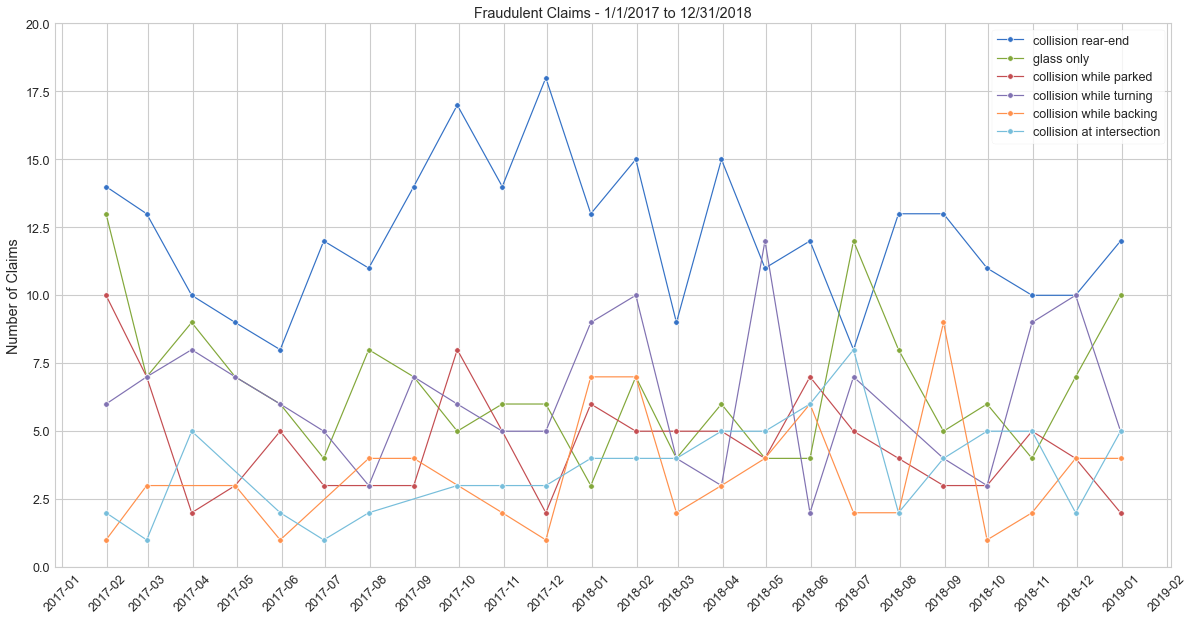

In [162]:
plt.figure(figsize= (20, 10))

for index, claim in enumerate(top_fraud_claims, start= 1):
    # temp dataframe with specific claim
    d = top_monthly_fraud[top_monthly_fraud['name'] == claim]
    ax = plt.gca()
    sns.lineplot(x= d.index, 
                 y= d.num_claims,
                 marker= 'o',
                 ax= ax)
ax.set_title(f"Fraudulent Claims - 1/1/2017 to 12/31/2018")
ax.set_ylabel("Number of Claims")
ax.set_xlabel("")
ax.set_ylim([0,20])
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.legend(top_fraud_claims)
plt.savefig(f'fraud_trends.png')

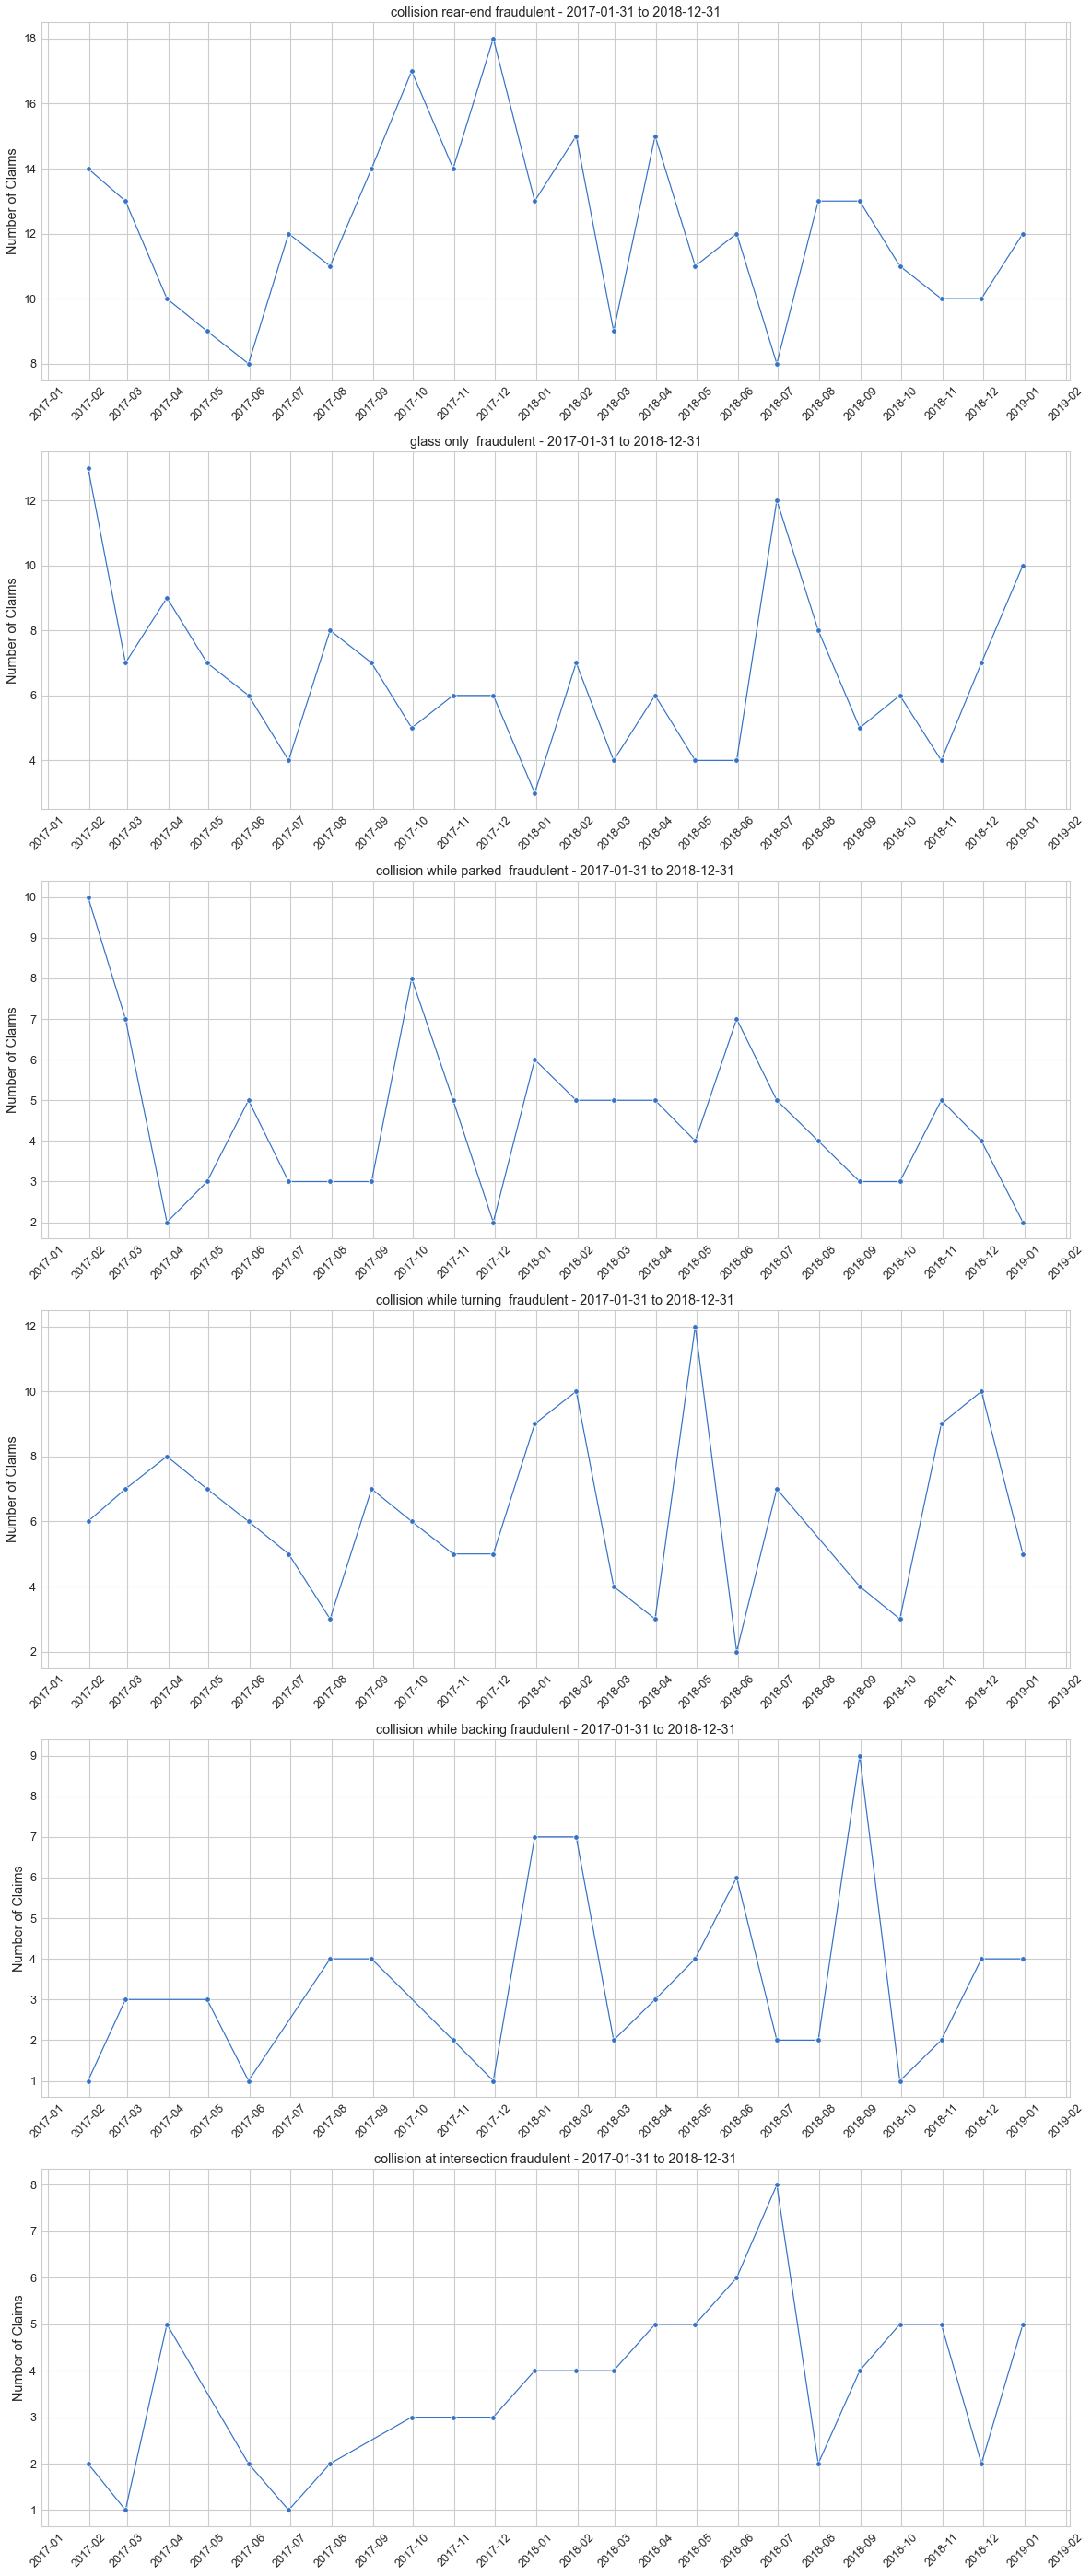

In [159]:
plt.figure(figsize= (20, 50))

for index, claim in enumerate(top_fraud_claims, start= 1):
    # temp dataframe with specific claim
    d = top_monthly_fraud[top_monthly_fraud['name'] == claim]
    min_date = d.index.min().strftime("%Y-%m-%d")
    max_date = d.index.max().strftime("%Y-%m-%d")
    
    plt.subplot(6,1, index)
    ax = plt.gca()
    sns.lineplot(x= d.index, 
                 y= d.num_claims,
                 marker= 'o',
                 ax= ax)
    ax.set_title(f"{claim} fraudulent - {min_date} to {max_date}")
    ax.set_ylabel("Number of Claims")
    ax.set_xlabel("")
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    plt.savefig(f'{claim}_fraud_trends.png')

Collision while backing fraud has increased over the two year period (4 -> 9), while collision while parked has dropped by nearly the same amount (10 -> 4). There has also been a general increase in fraud associated with collision while turning.

### Trends in real (non-fraudulent) claims

In [64]:
real = claims[claims['fraud'] == 0].copy()
real['lossdate'] = pd.to_datetime(real['lossdate'])
real = real.set_index("lossdate")

In [65]:
# get number of claims by month
monthly_real = real.groupby("name").resample("1m").size()

# reset index and rename column
monthly_real = monthly_real.reset_index(level= 'name').rename(columns= {0: 'num_claims'})

# sort in descending order by number of claims
monthly_real = monthly_real.groupby(by= 'lossdate').apply(lambda x: x.sort_values(["num_claims"], ascending= False))

# grab top 3 claims per month
monthly_real = monthly_real.reset_index(level = 1, drop= True).groupby(["lossdate"]).head(3)

In [66]:
# we see a total of 7 accidents most commonly associated with real
top_real_claims = monthly_real['name'].unique()
for claim in top_real_claims:
    print(claim)

collision rear-end
glass only 
collision while turning 
collision while parked 
collision at intersection


In [67]:
# grab monthly values for the top claims
top_monthly_real = monthly_real.groupby(["lossdate", "name"]).head()

In [68]:
for claim in top_real_claims:
    print(f"{claim:<25} has {(top_monthly_real['name'] == claim).sum():<2} elements")

collision rear-end        has 24 elements
glass only                has 23 elements
collision while turning   has 20 elements
collision while parked    has 4  elements
collision at intersection has 1  elements


In [69]:
# drop collision at intersection with only a single data point
top_real_claims = np.delete(top_real_claims, 4)
for claim in top_real_claims:
    print(claim)

collision rear-end
glass only 
collision while turning 
collision while parked 


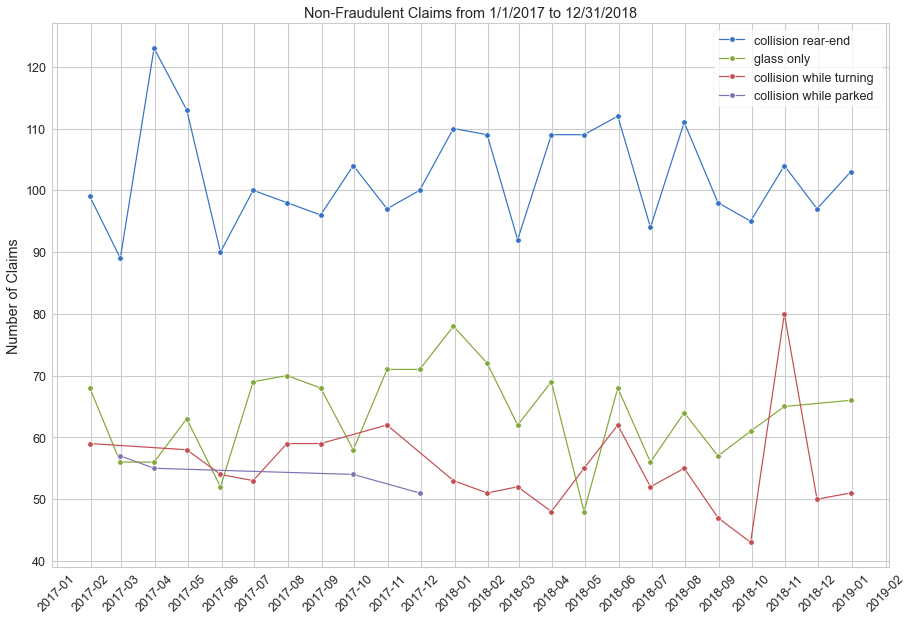

In [121]:
fig, ax = plt.subplots(figsize= (15,10))

for index, claim in enumerate(top_real_claims, start= 1):
    
    # temp dataframe with specific claim
    d = top_monthly_real[top_monthly_real['name'] == claim]
    d = d.reset_index()
    min_date = d.lossdate.min().strftime("%Y-%m-%d")
    max_date = d.lossdate.max().strftime("%Y-%m-%d")
    
    ax = plt.gca()
    sns.lineplot(x= d.lossdate, 
                 y= d.num_claims, 
                 marker= 'o',
                 ax= ax)
ax.set_title(f"Non-Fraudulent Claims from 1/1/2017 to 12/31/2018")
ax.set_ylabel("Number of Claims")
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.MonthLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.legend(top_real_claims)
plt.savefig(f'real_trends.png')

Collisions while parking dropped off the top 3 within the 2017 year. Slight trend downwards for collisions while turning.

# Model

In [71]:
y = claims["fraud"]
X = claims.drop(["fraud"], axis = 1)

# Drop claimnumber     - assumed to have no relationship with fraud
#      lossdate        - datetime does not work with RandomForest model. 
#                        converted to seconds since earliest date in EDA above.
#      bodily_injuries - very little information in this feature with all the missing values
X = X.drop(["claimnumber", "lossdate", "bodily_injuries"], axis = 1)

In [72]:
# OneHotEncoding to encode name, insured_sex, auto_make, insured_state, incident_severity, property_damage, bodily_injuries
# These are all categorical strings that need to be converted to numbers
# OneHotEncoding is preferred over LabelEncoder, for example, because OHE keeps the values binary
columns = ["name", "insured_sex", "auto_make", "insured_state", "incident_severity", "property_damage"]
ohe = OneHotEncoder(handle_unknown= 'ignore')
encoding = ohe.fit_transform(X[columns])
X = X.drop(columns, axis = 1)
X = pd.concat([X, pd.DataFrame(encoding.toarray())], axis = 1)

# split into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
# Additional features come from encoded variables
X_train.shape

(7442, 59)

In [174]:
np.mean(preds)

0.8898441698011822

In [170]:
# Baseline - predict all no fraud
preds = np.array(y_dev == 0, dtype = int)
accuracy = metrics.accuracy_score(y_dev, preds)
cm = metrics.confusion_matrix(y_dev, preds)
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)

print("Accuracy: ", accuracy)
print("Precision: ", precision)

Accuracy:  0.0
Precision:  0.0


Decision trees work well with structured data, start off with a Random Forest model.

In [74]:
# RF Model
clf = RandomForestClassifier() 
clf.fit(X_train, y_train)
prediction = clf.predict(X_dev)

# Metrics
accuracy = metrics.accuracy_score(y_dev, prediction)
confusion_matrix = metrics.confusion_matrix(y_dev, prediction)
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp)

print("Accuracy: ", accuracy)
print("Precision: ", precision)

Accuracy:  0.9650725416442772
Precision:  0.9430379746835443


The base accuracy of the RandomForest model is 0.965. Accuracy is comparing for each prediction, whether it matches the label or not. Precision looks at the difference between the number of actual fraud claims and the number of fraud claims the model made. The lower the precision, the more false positives the model made.

I focus on these two metrics as accuracy is a baseline score of how well the model is performing, which we naturally want to keep high. Secondary to accuracy is precision, which is a metric that follows the number of false positives the model makes. My goal from here is to maintain a high accuracy, but at the same time, look to raise the precision as high as possible.

Customers who are falsely accused of having a fradulent claim would rightfully get upset. This may spur additional actions from the customer including canceling their membership or spreading negative reviews on social media. To maintain a customer-focused perspective, raising the precision should be the top priority for the model.

In [75]:
false_positives = (y_dev == 0) & (prediction == 1)
index_fps = false_positives.index[false_positives == 1]

In [76]:
claims.iloc[index_fps, :]

,claimnumber,name,updatetime,lossdate,fault,fraud,insured_sex,insured_occupation,auto_make,months_as_customer,insured_state,incident_severity,property_damage,bodily_injuries,seconds_since_earliest_date
7077,43-4271,collision rear-end,1698.7,2018-08-22 17:35:00,100,0,male,4,SMART,2,CA,Trivial Damage,YES,NaN,51730380.0
4940,43-1222,glass only,1002.0,2017-02-09 05:59:00,0,0,male,6,OTHER,2,PA,Minor Damage,YES,NaN,3391020.0
8277,43-5908,collision while turning,2500.7,2017-04-01 05:30:00,0,0,female,4,MERCEDES-BENZ,2,CA,Total Loss,YES,NaN,7795680.0
3760,42-9444,collision rear-end,1810.4,2018-01-21 02:12:00,100,0,female,4,VOLKSWAGEN,2,CA,Minor Damage,YES,NaN,33271800.0
1556,42-6068,collision at intersection,1283.4,2018-04-09 17:34:00,0,0,female,4,SMART,2,CA,Major Damage,NO,NaN,40066320.0
8624,43-6340,collision rear-end,3422.0,2017-04-10 19:47:00,0,0,nonconforming,6,TOYOTA,2,CA,Total Loss,NO,NaN,8624700.0
6563,43-3527,collision while parked,1112.9,2018-12-06 01:49:00,0,0,female,5,SUBARU,2,CA,Minor Damage,?,NaN,60832020.0
7119,43-4342,glass only,1005.0,2017-04-20 22:20:00,0,0,female,1,SUZUKI,2,PA,Total Loss,?,NaN,9497880.0
7901,43-5377,collision rear-end,2268.9,2017-01-17 18:58:00,100,0,male,4,SUBARU,2,CA,Major Damage,NO,NaN,1450560.0


We see that all of the false positives have "months_as_customer" at 2. 

In [77]:
# Find the top 10 features
kbest = SelectKBest(f_classif, k= 'all')
X_train_kbest = kbest.fit_transform(X_train, y_train)
X_dev_kbest = kbest.transform(X_dev)

pd.Series(kbest.scores_).sort_values(ascending=False)[:10]

3     2745.495701
8        5.709716
24       3.819512
56       3.068571
36       2.850561
17       2.682101
12       2.551358
0        2.256510
37       2.227166
27       2.001493
dtype: float64

Incredible predictive/feature importance for feature 3 (months_as_customer), which unfortunately is where it seems our false positives originate from.

Next, I'll tune the model using RandomSearchCV, which randomly selects from a range of hyperparameters. 

In [78]:
# Initialize feature selection and random forest pipeline
kbest = SelectKBest()
rf = RandomForestClassifier()
pipe = Pipeline([('kbest', kbest), ('rf', clf)])

# Create param grid with wide ranges
score_func = [chi2, f_classif, mutual_info_classif]
k = [int(i) for i in np.linspace(1,21,6)]
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]
max_features = [int, float, "auto", "log2"]
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
max_depth.append(None)
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 5, 10]

random_param_grid = {
    "kbest__score_func": score_func,
    "kbest__k": k,
    "rf__n_estimators": n_estimators,
    "rf__max_features": max_features,
    "rf__max_depth": max_depth,
    "rf__min_samples_split": min_samples_split,
    "rf__min_samples_leaf": min_samples_leaf
}

# Find best parameters (as determined by RSCV) and predict on it
search = RandomizedSearchCV(pipe, random_param_grid, n_jobs= -1)
search.fit(X_train, y_train)
prediction = search.predict(X_dev)

# Metrics
accuracy = metrics.accuracy_score(y_dev, prediction)
confusion_matrix = metrics.confusion_matrix(y_dev, prediction)
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp)

print(f"Accuracy: {accuracy: .4f}")
print(f"Precision: {precision: .4f}")

Accuracy:  0.9833
Precision:  0.9943


Using a basic RandomSearchCV, we're able to moderately increase accuracy from 96% to 98%. More importantly, our precision has greatly increased to above 99%. This means that for each positive fraud prediction that the model makes, it very nearly is always correct. Our original goal was a customer-focused one: to lower false positives while still maintaining a high accuracy. With this tuned model, I feel comfortable heading into the test set.

## Test

In [79]:
prediction = search.predict(X_test)

# Metrics
accuracy = metrics.accuracy_score(y_test, prediction)
confusion_matrix = metrics.confusion_matrix(y_test, prediction)
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp)

print(f"Accuracy: {accuracy: .2f}")
print(f"Precision: {precision: .2f}")

Accuracy:  0.98
Precision:  1.00


The model developed using the train and development data help up well to the test data. The accuracy and precision were what we expected given the dev data results. Because we held out the test data from the beginning, I am confident that the model is generalizable to new data.

# Model Thoughts and Conclusions

The baseline dataset had roughly 10% of the claims as fraud. This set our baseline at 90% accuracy just based on having a naive model of always saying that the claim was not fraud.

Because the data I was given to work with was structured, I decided to use a RandomForest model as I know it performs well with structured data. The base model gave us a modest increase to an accuracy of 96%. When thinking more about the problem, I think back to the [spam classification problem](http://www.paulgraham.com/spam.html). What is important in fraud detection and in spam email is the utmost need to avoid false positives. 

You can adjust numbers to compensate for some losses due to fraud, but what has much more variance and is more difficult to quantify is the effect of labeling claims as fraud when it in fact is not fraud. Customers complain on social media and to their friends and suddenly what should have been a small issue has now ballooned to a much bigger one. 

Moving forward, my goal was still to keep accuracy high, but really aim to have the false positive rate to be as low as possible. I used SelectKBest to quantify the relative feature importances. It turns out that the months that a customer has been with us is by far the strongest indicator as to whether the claim would be fraudulent or not.

I hyperparameter tuned the model using RandomSearchCV and found that I was quickly able to achieve another boost in accuracy, but more importantly, a significant increase to precision. The hyperparameter tuning brought the precision up to over 99%, which is better than I expected. Happy with the result, I ran the tuned model on the test set and found that the accuracy and precision numbers hold up with data not used during tuning as well.